# EDA

- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [1]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from pprint import pprint
from functions_variables import threshold_column, ohe_column, json_to_df, reorder_columns_train_test, year_sold_listed, fill_na_with_distribution_train_test, fill_na_with_median_train_test, scale_columns_train_test, scale_target_train_test
from collections import Counter
from sklearn.model_selection import train_test_split


## Data Importing

In [2]:
# load one file first to see what type of data you're dealing with and what attributes it has
tmp_df = pd.read_json('../data/housing/AK_Juneau_0.json')
# tmp_df['data']['results']

In [3]:
# Create empty DataFrame for housing
df = pd.DataFrame()
# The path to the data files
dir_path = '../data/housing/'

In [4]:
# loop over all files and put them into a dataframe
# n = 0
for file_name in sorted(os.listdir(dir_path)):
    # n += 1
    if file_name.endswith('.json'):
        # print(f'File: {file_name}')
        file_path = os.path.join(dir_path, file_name)
        tmp = json_to_df(file_path)
        tmp = tmp.dropna(axis=1, how='all')
        df = pd.concat([df, tmp], ignore_index=True)
    # if n > 1: break
# df

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [5]:
df.shape

(8191, 50)

In [6]:
columns = df.columns.sort_values().to_list()
# columns

In [7]:
# Rearrange DataFrame columns
df = df[columns]

In [8]:
# drop or replace values as necessary
df = df.drop(
    columns=[
        'branding',
        'community_advertisers',
        'community_description_name',
        # 'description.baths',
        'description_baths_3qtr',
        'description_baths_full',
        'description_baths_half',
        # 'description.beds',
        # 'description.garage',
        'description_lot_sqft',
        # 'description.sold_date',
        # 'description.sold_price',
        # 'description.sqft',
        # 'description.stories',
        'description_sub_type',
        'description_type',
        # 'description.year_built',
        'flags_is_foreclosure',
        'flags_is_new_listing',
        'flags_is_price_reduced',
        'last_update_date',
        'lead_attributes_show_contact_an_agent',
        #'list_date',
        # 'list_price',
        'listing_id',
        #'location_address_city',
        'location_address_coordinate_lat',
        'location_address_coordinate_lon',
        'location_address_line',
        'location_address_postal_code',
        # 'location.address.state',
        'location_address_state_code',
        'location_county_fips_code',
        'location_county_name',
        'location_street_view_url',
        'matterport',
        'other_listings_rdc',
        'permalink',
        'photos',
        'price_reduced_amount',
        'primary_photo_href',
        'products_brand_name',
        'property_id',
        'source_agents',
        'source_plan_id',
        'source_spec_id',
        'source_type',
        'status',
        # 'tags',
        'virtual_tours'
    ],
    errors='ignore'
)

In [9]:
#Clean the data

df['description_garage'] = df['description_garage'].fillna(0)

df['description_stories'].value_counts()

df = df[~df['description_stories'].isin([10.0, 8.0, 6.0])]

df = df.dropna(subset=['description_sold_price'])




In [10]:
# Convert to datetime format

df['list_date'] = df['list_date'].astype(str)

df['list_date'] = df['list_date'].str.extract(r'(\d{4}-\d{2}-\d{2})')

df['list_date'] = pd.to_datetime(df['list_date'], format='%Y-%m-%d', errors='coerce')

df['description_sold_date'] = pd.to_datetime(df['description_sold_date'], errors='coerce')

In [11]:
#drop list_price
df = df.drop(columns=['list_price'])

In [12]:
#Calculate the year the house was sold and the year it was listed

df = year_sold_listed(df)


### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [13]:
# One-Hot Encode the columns, considering low frequency removal for 'tags'

if 'tags' in df.columns:
    # Flatten all tags into a single list
    all_tags = df['tags'].dropna().sum()

    # Count occurrences of each tag
    tag_counts = Counter(all_tags)

    # Convert to a DataFrame for easier review
    tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])

    # Sort by count (descending order)
    tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

    # Display top tags
    print(tag_counts_df)

#set option to display all the rows
pd.set_option('display.max_rows', None)    

                         Tag  Count
12          garage_1_or_more   3772
0                central_air   3414
2    community_outdoor_space   3095
6                 dishwasher   2965
44                  basement   2914
..                       ...    ...
117          courtyard_entry      5
148               greenhouse      5
127              two_kitchen      5
150                boat_dock      5
151      dual_master_bedroom      5

[152 rows x 2 columns]


In [14]:
# List of selected tags for one-hot encoding
selected_tags = [
    "central_air", "community_outdoor_space", "basement", "fireplace",
    "hardwood_floors", "recreation_facilities", "community_security_features",
    "view", "central_heat", "city_view", "fenced_yard"
]

# Ensure the tags column exists
if 'tags' in df.columns:
    # Replace NaN in the tags column with an empty list
    df['tags'] = df['tags'].apply(lambda x: x if isinstance(x, list) else [])
    
    # Create one-hot encoding columns for selected tags
    for tag in selected_tags:
        df[tag] = df['tags'].apply(lambda x: 1 if tag in x else 0)

#drop tags column
df = df.drop(columns=['tags'])

In [15]:
# Calculate the number of days on the market
df['days_on_market'] = (df['description_sold_date'] - df['list_date']).dt.days

# Preview the result
print(df[['list_date', 'description_sold_date', 'days_on_market']].head())

    list_date description_sold_date  days_on_market
30 2023-12-19            2024-01-16            28.0
31 2023-11-10            2024-01-16            67.0
32 2023-12-19            2024-01-16            28.0
33 2023-07-05            2024-01-16           195.0
34 2023-10-29            2024-01-12            75.0


In [16]:
#change all the negative values on days_on_the_market to NaN
df.loc[df['days_on_market'] < 0, 'days_on_market'] = np.nan



In [17]:
#drop description_sold_date and list_date
df = df.drop(columns=['description_sold_date', 'list_date'])

In [18]:
#drop rows with description_sold_price >= 2500000 and <= 100000
df = df[df['description_sold_price'] >= 100000]
df = df[df['description_sold_price'] <= 2500000]



In [19]:
# Drop rows with 3 or more NaN values
df = df.dropna(thresh=len(df.columns) - 3 + 1)  

# Verify the result
print(f"Number of rows after dropping: {len(df)}")


Number of rows after dropping: 5639


### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [20]:
# Define feature set and target variable
X = df.drop(columns=['description_sold_price'])
y = df['description_sold_price']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (4511, 22), y_train shape: (4511,)
X_test shape: (1128, 22), y_test shape: (1128,)


In [21]:
if 'location_address_city' in X_train.columns:
    # Calculate city frequencies based only on training data
    city_counts = X_train['location_address_city'].value_counts()
    
    # Map frequencies to both training and test sets
    X_train['city_frequency'] = X_train['location_address_city'].map(city_counts)
    X_test['city_frequency'] = X_test['location_address_city'].map(city_counts)
    print("Frequency encoding applied to 'city' column for train and test sets.")

if 'location_address_state' in X_train.columns:
    # Calculate state frequencies based only on training data
    state_counts = X_train['location_address_state'].value_counts()
    
    # Map frequencies to both training and test sets
    X_train['state_frequency'] = X_train['location_address_state'].map(state_counts)
    X_test['state_frequency'] = X_test['location_address_state'].map(state_counts)
    print("Frequency encoding applied to 'state' column for train and test sets.")

Frequency encoding applied to 'city' column for train and test sets.
Frequency encoding applied to 'state' column for train and test sets.


In [22]:
#Drop location_address_city and location_address_state
X_train = X_train.drop(columns=['location_address_city', 'location_address_state'])
X_test = X_test.drop(columns=['location_address_city', 'location_address_state'])


In [23]:
# List of columns to fill
columns_to_fill = ['description_baths', 'description_beds', 'description_garage', 'description_stories']

# Apply the function to each column
for col in columns_to_fill:
    X_train, X_test = fill_na_with_distribution_train_test(X_train, X_test, col)



In [24]:
# List of columns to fill with median
columns_to_fill_median = [
    'days_on_market', 'city_frequency', 'state_frequency',
    'description_sqft', 'description_year_built',
    'year_sold', 'year_listed'
]

# Apply the function to each column
for col in columns_to_fill_median:
    X_train, X_test = fill_na_with_median_train_test(X_train, X_test, col)


In [25]:
# List of columns to scale
columns_to_scale = [
    'description_baths', 'description_beds', 'description_garage',
    'description_sqft', 'description_stories', 'description_year_built',
    'year_sold', 'year_listed', 'days_on_market', 'city_frequency', 'state_frequency'
]

# Apply scaling to the train and test sets
X_train_scaled, X_test_scaled, scaler_features = scale_columns_train_test(X_train, X_test, columns_to_scale)
y_train_scaled, y_test_scaled, scaler_target = scale_target_train_test(y_train, y_test)

# Verify scaled columns and target
print("Scaled X_train:", X_train_scaled[columns_to_scale].head())
print("Scaled y_train:", y_train_scaled.head())

Scaled X_train:       description_baths  description_beds  description_garage  \
1860           1.719936          0.590194            0.722632   
5392           0.689710         -0.218298           -0.120782   
443            0.689710          0.590194            0.722632   
5854           0.689710          0.590194            1.566046   
4011          -1.370742         -0.218298           -0.964195   

      description_sqft  description_stories  description_year_built  \
1860          0.310417             2.243998                0.876046   
5392         -0.459942             0.671177                1.494672   
443           0.739957             0.671177                1.072881   
5854          0.703170            -0.901644                0.763568   
4011         -0.569220            -0.901644               -2.160848   

      year_sold  year_listed  days_on_market  city_frequency  state_frequency  
1860   0.734568    -0.089851       -0.134212       -0.172481        -0.061801  
5392  

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [29]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [30]:
print(y_train.describe())

count    4.511000e+03
mean     4.060560e+05
std      2.887504e+05
min      1.000000e+05
25%      2.272500e+05
50%      3.320000e+05
75%      4.850000e+05
max      2.500000e+06
Name: description_sold_price, dtype: float64


In [36]:
#check for correlations between the features and the target variable
correlation = X_train.corrwith(y_train).sort_values(ascending=False)
print(correlation)


description_sqft               0.509591
description_baths              0.475655
description_garage             0.301239
community_security_features    0.272911
fireplace                      0.230847
description_beds               0.226391
view                           0.199368
hardwood_floors                0.171537
recreation_facilities          0.168641
description_year_built         0.116526
description_stories            0.112619
days_on_market                 0.109374
year_listed                    0.094611
community_outdoor_space        0.059470
basement                       0.044304
year_sold                      0.040330
city_frequency                 0.025099
city_view                      0.022971
central_air                    0.013113
state_frequency                0.011265
central_heat                  -0.007216
fenced_yard                   -0.093549
dtype: float64


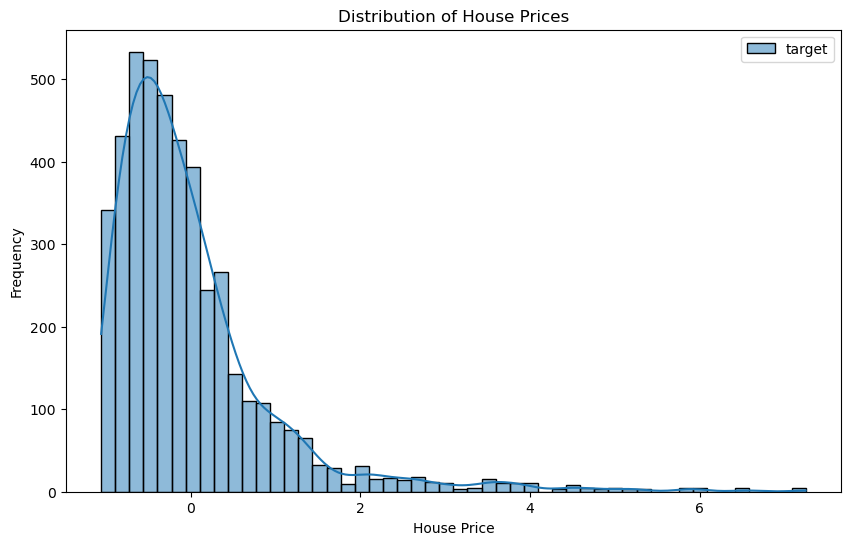

In [35]:
# perform EDA here


plt.figure(figsize=(10, 6))
sns.histplot(y_train_scaled, kde=True, bins=50, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.show()


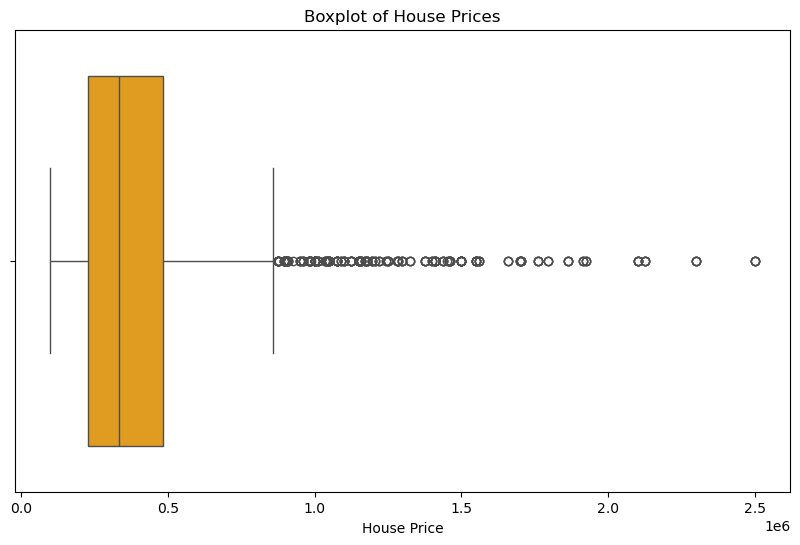

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_train, color='orange')
plt.title('Boxplot of House Prices')
plt.xlabel('House Price')
plt.show()

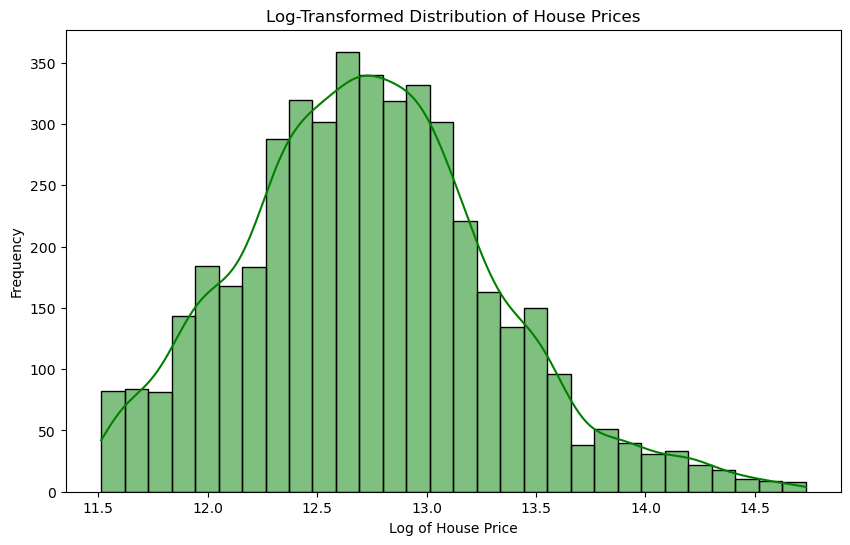

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(y_train), kde=True, bins=30, color='green')  
plt.title('Log-Transformed Distribution of House Prices')
plt.xlabel('Log of House Price')
plt.ylabel('Frequency')
plt.show()

## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [ ]:
#reorder columns for train and test x and y data
X_train_scaled, X_test_scaled = reorder_columns_train_test(X_train_scaled, X_test_scaled)
y_train_scaled, y_test_scaled = reorder_columns_train_test(y_train_scaled, y_test_scaled)


In [39]:
X_train_scaled.to_csv('/home/t0si/LHL-Midterm-Project/notebooks/processed/X_train.csv', index=False)
X_test_scaled.to_csv('/home/t0si/LHL-Midterm-Project/notebooks/processed/X_test.csv', index=False)
y_train_scaled.to_csv('/home/t0si/LHL-Midterm-Project/notebooks/processed/y_train.csv', index=False)
y_test_scaled.to_csv('/home/t0si/LHL-Midterm-Project/notebooks/processed/y_test.csv', index=False)